<a href="https://colab.research.google.com/github/sdfjslfjafkdl/Deep-Learning-Base-5/blob/main/step05/step05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 설치

In [12]:
import numpy as np
import matplotlib.pyplot as plt

## EM 알고리즘 구현

### 데이터셋과 GMM 코드

In [13]:
xs = np.loadtxt('old_faithful (1).txt')
print(xs.shape)

# 매개변수 (초깃값)
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis) # 가우스 분포의 개수
N = len(xs) # 데이터 수
MAX_ITERS = 100 # EM 알고리즘의 최대 반복 횟수
THRESHOLD = 1e-4 # EM 알고리즘 갱신 중지 임계값. 매개변수 갱신 후 로그 가능도 차이의 절댓값이 이 이하로 떨어지면 갱신 종료

(272, 2)


In [14]:
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

# 로그 가능도의 평균 계산 -> EM 알고리즘 종료조건에 이용
def likelihood(xs, phis, mus, covs):
    """ log likelihood """
    eps = 1e-8 # log(0) 방지 위한 아주 작은 값
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps) # y = 0일 경우 방지하여 eps 더해줌
    return L / N

### E-step & M-step 구현

In [15]:
current_likelihood = likelihood(xs, phis, mus, covs)

for iter in range(MAX_ITERS):

  # E-step

  qs = np.zeros((N, K))
  for n in range(N):
    x = xs[n]
    for k in range(K):
      phi, mu, cov = phis[k], mus[k], covs[k]
      qs[n, k] = phi * multivariate_normal(x, mu, cov)
    qs[n] /= gmm(x, phis, mus, covs)

  # M-step

  qs_sum = qs.sum(axis = 0) # q(1) ~ q(N)까지의 sum. M-step에서 자주 활용할 일이 많아서 한 번에 계산해놓음
  for k in range(K):
    # 1. phis
    phis[k] = qs_sum[k] / N

    # 2. mus
    c = 0
    for n in range(N):
      c += qs[n, k] * xs[n]
    mus[k] = c / qs_sum[k]

    # 3. covs
    c = 0
    for n in range(N):
      z = xs[n] - mus[k]
      z = z[:, np.newaxis] # 수식과 일치시키기 위해 열벡터 사용
      c += qs[n, k] * z @ z.T
    covs[k] = c / qs_sum[k]

  # 종료 판정 코드

  print(f'{current_likelihood:.3f}')

  next_likelihood = likelihood(xs, phis, mus, covs)
  diff = np.abs(next_likelihood - current_likelihood)
  if diff < THRESHOLD:
    break
  current_likelihood = next_likelihood

-16.538
-4.415
-4.357
-4.302
-4.245
-4.200
-4.164
-4.156
-4.155


### 시각화

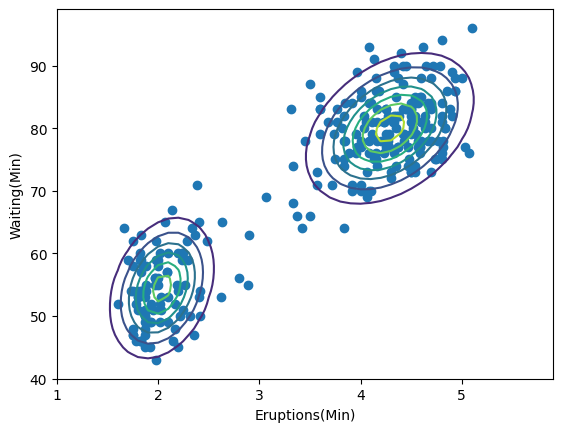

In [16]:
# visualize
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

plt.scatter(xs[:,0], xs[:,1])
plot_contour(phis, mus, covs)
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()
# 두 개 덩어리에 정규분포가 적합하게 분포돼 있는 것 확인